![Dash](https://plotly-marketing-website.cdn.prismic.io/plotly-marketing-website/948b6663-9429-4bd6-a4cc-cb33231d4532_logo-plotly.svg "Dash")
## **Boruta＋SHAP＋dtreeviz**
データセットから重要な特徴量を選び、シンプルな決定木を描くまでを自動化したものです。\
データセットのアップロード後、データセット可視化、前処理、特徴量選択、SHAP値表示（回帰のみ）、決定木分析を自動実行します。

**※データセットに数多くの欠損値や異常データがあり、別途 前処理を行いたい場合は、まずコレ→ [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hima2b4/Auto_Profiling/blob/master/Data_Preprosessing.ipynb) を実行してください。**

<details><summary>概要説明 :</summary><div>

- 回帰（Regression）・分類（Classification）データのいずれも実行可能です。
- **結果に影響する重要な特徴量を選び、その上で特徴量と結果の関係性をSHAP値による散布図と決定木で示します**ので、**どのようなケースが結果に影響しているかが掴めます**。



<details><summary>dataset について : 
データをアップロードする場合は [ Upload ]を選択してください。Boston_housing :regression / Diabetes :regression / Breast_cancer :binary / Titanic :binary / Iris :classification / Loan_prediction :binary はデータセットサンプルです。</summary><div>

- Boston_housing :regression　← ボストン市郊外の「犯罪発生率」や「広い部屋の割合」等と「住宅価格」の回帰データ。欠損値なし。すべてのカラムが数値のデータ。

- Diabetes :regression　← 糖尿病患者の「年齢」「性別」と「8項目の診断データ」と「1年後の進行度（数値）」の回帰データ。欠損値なし。「8項目の診断データ」は標本平均と標本分散で標準化（平均0, 標準偏差1）されている。

- Breast_cancer :binary　← 乳がんのさまざまな「診断データ」と「陽性・陰性（陽性:1, 陰性:0）」の二値分類データ。欠損値なし。すべてのカラムが数値のデータ。

- Titanic :binary　← タイタニック号 乗客者の「性別」「年齢」「チケットクラス」等と「生存情報（Survived）」のデータ。Survived：0（死亡）,1（生存）の二値分類。欠損値があり、文字列のカラムも複数あるデータ。

- Iris :classification　← 「がく片」「花びらの幅」「長さ」と「3種類のアヤメ [Setosa, Virginia, Versicolor]」 の分類データ。欠損値なし。分類データである [Setosa, Virginia, Versicolor] は文字データ。

- Loan_prediction :binary　←　住宅ローン顧客の「性別」「配偶者の有無」「学歴」「扶養家族の数」「収入」「融資額」「クレジットヒストリー」などの情報と「ローン承認のStatus：Loan_Status(Y/N)」の二値分類データ。欠損値があり、文字列カラムも複数あるデータ。分類データである「Loan_Status」も 文字データ[Y,N] となっている。

- Upload　← 任意のデータセットを読み込む場合はこれを選択してください。
</div></details>
<details><summary>dataset_typeについて ：Classification（分類データ）か Regression（回帰データ）のいずれかを選択してください。</summary><div>

In [ ]:
#@title **Select_Dataset** { run: "auto" }
dataset = 'Diabetes :regression' #@param ['Boston_housing :regression', 'Diabetes :regression', 'Breast_cancer :binary','Titanic :binary', 'Iris :classification', 'Loan_prediction :binary', 'Upload']

#@title **Classification**（分類）or **Regression**（回帰）
dataset_type = 'Regression' #@param ["Classification", "Regression"]

### **ライブラリのインストール**

In [ ]:
!pip install shap -q

In [ ]:
pip install Boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install dataprep

In [ ]:
!pip install dtreeviz --quiet

In [ ]:
# ライブラリのインポート
import pandas as pd # 基本ライブラリ
import numpy as np # 基本ライブラリ
import matplotlib.pyplot as plt # グラフ描画用
import seaborn as sns; sns.set() # グラフ描画用
#from dataprep.eda import create_report
#from dataprep.datasets import load_dataset
#from dataprep.eda import plot, plot_correlation, plot_missing, plot_diff
import warnings
warnings.filterwarnings('ignore')

### **Load dataset**



In [ ]:
#@title **Load Dataset**
if dataset =='Upload':
  from google.colab import files
  uploaded = files.upload()#Upload
  target = list(uploaded.keys())[0]
  df = pd.read_csv(target)

elif dataset == "Diabetes :regression":
  from sklearn.datasets import load_diabetes
  dataset = load_diabetes()
  df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
  df["target"] = dataset.target

elif dataset == "Breast_cancer :binary":
  from sklearn.datasets import load_breast_cancer
  dataset = load_breast_cancer()
  df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
  df["target"] = dataset.target

elif dataset == "Titanic :binary":
  data_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
  df = pd.read_csv(data_url)
  X = df.drop(['Survived'], axis=1) # 目的変数を除いたデータ
  y = df['Survived'] # 目的変数
  df = pd.concat([X, y], axis=1)

elif dataset == "Iris :classification":
  from sklearn.datasets import load_iris
  dataset = load_iris()
  df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
  df["target"] = dataset.target

elif dataset == "Loan_prediction :binary":
  data_url = "https://github.com/shrikant-temburwar/Loan-Prediction-Dataset/raw/master/train.csv"
  df = pd.read_csv(data_url)

else:
  from sklearn.datasets import load_boston
  dataset = load_boston()
  df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
  df["target"] = dataset.target

#X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
#y = pd.Series(dataset.target, name='target')

source = df.copy()

FEATURES = df.columns[:-1]
TARGET = df.columns[-1]
X = df.loc[:, FEATURES]
y = df.loc[:, TARGET]

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [ ]:
#@title **Datasetの数字・文字列区分**
numerical_col = []
Object_col = []

for col_name, item in df.iteritems():
    if item.dtype == object:
        Object_col.append(col_name)
    else:
        numerical_col.append(col_name)
        
print('-----------------------------------------------------------------------------------------')
print('[数字カラム一覧]')
print('Numerical_colomn:', numerical_col)
print('-----------------------------------------------------------------------------------------')
print('[文字カラム一覧]')
print('Object_colomn:', Object_col)
print('-----------------------------------------------------------------------------------------')
print('※ 前処理でカラムを指定する場合は、上記に表示されたカラムを Copy & Paste するとよい')

-----------------------------------------------------------------------------------------
[数字カラム一覧]
Numerical_colomn: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target']
-----------------------------------------------------------------------------------------
[文字カラム一覧]
Object_colomn: []
-----------------------------------------------------------------------------------------
※ 前処理でカラムを指定する場合は、上記に表示されたカラムを Copy & Paste するとよい


### **前処理の選択**
<details><summary>実行できる前処理について</summary><div>

データセットに文字データや欠損値がある場合、決定木分析が実行できませんので、以下のような前処理メニューを設けています。
- **デフォルト設定**は、① 7割以上欠損値があるカラム（列）を削除、② カラム名に[ID][Lot]を含む列を削除、③ 欠損値がある行データを削除、④ 16進数データを10進数に変換、⑤ 文字列データをカテゴリー（数値）変換、⑥ 文字列データがあれば削除、⑦ 日本語カラムを英語翻訳 としています。
- ①～⑦は、実行する／しないが設定できます。
- **基本的には、上から順に実行するようにしてください。**（※先に③を実行すると多くのデータが削除されます。⑤は欠損値を削除する前に実行すると欠損値もカテゴリー化してしまいます。）
- 上記以外に、削除カラム（列）の個別指定、ラベルエンコーディングの個別指定も可能です。（※欠損値や文字列データが残っていると以降の処理でエラーとなりますので注意してください。）
- Uploadする**データに欠損値がなく、かつすべて数値データである場合、これら前処理は実行の対象となりませんので何も影響はありません。**
- ラベルエンコーディングは、例えば [優] [良] [可] [不可] を [0] [1] [2] [3] とする処理です。数値は 0～ 割り振られます。該当の前処理セル実行後、[優、良、可]等と表示されます。[優, 良, 可]＝[0, 1, 2] という対応になります。

In [ ]:
#@title **削除する列を指定**
#@markdown  **<font color= "Crimson">注意</font>：指定は <u> ' ID ' , ' Age ' , </u> などとしてください。**</font>
Drop_label_is = '' #@param {type:"raw"}

try:
  if Drop_label_is is not "":
    Drop_label_is = pd.Series(Drop_label_is)
    df.drop(columns=list(Drop_label_is),axis=1,inplace=True)
  else:
    print('※削除カラムの指定なし→処理スキップ')
except:
    print("※正常に処理されませんでした。入力に誤りがないか確認してください。")

df.head()

※削除カラムの指定なし→処理スキップ


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [ ]:
#@title **7割欠損値がある列を削除（☑ ＝実行）**
Over_70percent_missing_value_is_drop = True #@param {type:"boolean"}

#各列ごとに、6割欠損がある列を削除
if Over_70percent_missing_value_is_drop == True:
  for col in df.columns:
    nans = df[col].isnull().sum()  # nanになっている行数をカウント

    # nan行数を全行数で割り、7割欠損している列をDrop
    if nans / len(df) > 0.7: 
        # 7割欠損列を削除
        print('-----------------------------------------------------------------------------------------')
        print('[削除カラム一覧]')
        print("drop column:", col)
        print('-----------------------------------------------------------------------------------------')
        df.drop(col, axis=1, inplace=True)    
#    else:
#      print(col,'：OK ⇒ 処理スキップ')
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [ ]:
#@title **カラム名に [ID] [Lot] を含む列を削除（☑ ＝実行）**
Drop_ID_label = True #@param {type:"boolean"}

include_list = df.columns[df.columns.str.contains('ID|Lot',case=False)]

if Drop_ID_label == True:
  if include_list is not "":
    df.drop(columns=list(include_list),axis=1,inplace=True)
    print('-----------------------------------------------------------------------------------------')
    print('[削除カラム一覧]')
    print("drop column:", list(include_list))
    print('-----------------------------------------------------------------------------------------')
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [ ]:
#@title **欠損値がある行を削除（☑ ＝実行）**
Null_Drop  = True #@param {type:"boolean"}

if Null_Drop == True:
  df = df.dropna(how='any')
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [ ]:
#@title **HEX(16進数)列をINT(10進数)に変換（☑ ＝実行）**
HEX_to_INT  = False #@param {type:"boolean"}

import string
if HEX_to_INT == True:
  for col in df.columns:
    if df[col].dtype == 'object':
      if all(df[col].apply(lambda x: set(x).issubset(set(string.hexdigits)))) ==True:
        df[col]=df[col].apply(lambda x:int(x, 16))
#    else:
#      print(col,'=int →処理スキップ')
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [ ]:
#@title **Label encording する Obeject_col を指定**
#@markdown  **<font color= "Crimson">注意</font>：指定は <u> ' ID ' , ' Age ' , </u> などとしてください。**
Object_label_to_encode_is = '' #@param {type:"raw"}

from sklearn.preprocessing import LabelEncoder

try:
  for i in Object_label_to_encode_is:
    if Object_label_to_encode_is is not "":
      le = LabelEncoder()
      Object_label_to_encode_is = pd.Series(Object_label_to_encode_is)
      df[i] = le.fit_transform(df[i].astype(str))
      print('-----------------------------------------------------------------------------------------')
      print(i)
      print(le.classes_, "= [0, 1, 2...]" )

    else:
      print('※エンコード指定カラムなし→処理スキップ')
except:
    print("※正常に処理されなかった場合は入力に誤りがないか確認してください。")

print('-----------------------------------------------------------------------------------------') 
df.head()

-----------------------------------------------------------------------------------------


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [ ]:
#@title **すべての Obeject_col を Label encord（☑ ＝実行）**
Encord_all_object_label = True #@param {type:"boolean"}

if Encord_all_object_label == True:
  le = LabelEncoder()

  for col in df.columns:
    if df[col].dtype == 'object':
      df[col] = le.fit_transform(df[col].astype(str))
      print('-----------------------------------------------------------------------------------------') 
      print(col)
      print(le.classes_, "= [0, 1, 2...]" )
     
#    else:
#      print(col,'：エンコードしない→処理スキップ')

print('-----------------------------------------------------------------------------------------') 
df.head()

-----------------------------------------------------------------------------------------


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [ ]:
#@title **すべての文字列データを削除（☑ ＝実行）**
Exclude_Object = True #@param {type:"boolean"}

#数値の列は残し、文字列だけを削除
if Exclude_Object == True:
  df = df.select_dtypes(exclude='object')

df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [ ]:
#@title **カラム名を英訳（☑ ＝実行）**
Column_English_translation = True #@param {type:"boolean"}

if Column_English_translation == True:
  !pip install googletrans==4.0.0-rc1 --quiet
  from googletrans import Translator

  eng_columns = {}
  columns = df.columns
  translator = Translator()
  
  for column in columns:
    eng_column = translator.translate(column).text
    eng_column = eng_column.replace(' ', '_')
    eng_columns[column] = eng_column
    df.rename(columns=eng_columns, inplace=True)

print('-----------------------------------------------------------------------------------------')
print('[カラム名_英訳結果（翻訳しない場合も表示）]')
print('-----------------------------------------------------------------------------------------') 
df.head(0)

-----------------------------------------------------------------------------------------
[カラム名_英訳結果（翻訳しない場合も表示）]
-----------------------------------------------------------------------------------------


,age,sex,bmi,bp,S1,Bad,CZ,sample,s5,ot,target


### **Boruta**

In [ ]:
#@title **Preparation of Boruta** ‐Random forest-
# 全特徴量による学習（random forest）
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

#X,yを再設定
FEATURES = df.columns[:-1]
TARGET = df.columns[-1]
X = df.loc[:, FEATURES]
y = df.loc[:, TARGET]

#RF実行
if dataset_type == 'Regression':
  pre_rf = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=0)
else:
  pre_rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=0)

#pre_rf = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=0)
pre_rf.fit(X, y)
print('SCORE with ALL Features: %1.3f\n' % pre_rf.score(X, y))

SCORE with ALL Features: 0.711



In [ ]:
#@title **Feature selection with Boruta**

# 全特徴量による学習（random forest）
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

#X,yを再設定
FEATURES = df.columns[:-1]
TARGET = df.columns[-1]
X = df.loc[:, FEATURES]
y = df.loc[:, TARGET]

#RF実行
if dataset_type == 'Regression':
  pre_rf = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=0)
else:
  pre_rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=0)

#pre_rf = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=0)
pre_rf.fit(X, y)
print('SCORE with ALL Features: %1.3f\n' % pre_rf.score(X, y))

# RandomForestでBorutaを実行
from boruta import BorutaPy

feat_selector = BorutaPy(pre_rf, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(X.values, y.values)

SCORE with ALL Features: 0.711

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	4
Rejected: 	3
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	4
Rejected: 	3
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	4
Rejected: 	3
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	4
Rejected: 	3
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	4
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	4
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	4
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	4
Iteration: 	16 / 100
Confirmed: 	4
Tenta

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=69,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7FD618F78050),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FD618F78050, verbose=2)

### **Result of feature selection**

In [ ]:
#@title **Decision rank by Boruta & SHAP_mean value**

#Display_result_selection = True #@param {type:"boolean"}


#Borutaによる特徴量選択結果(bool値,rank)をdf1に格納
#Selected (i.e., estimated best) features are assigned rank 1 and tentative features are assigned rank 2.
df1 = pd.DataFrame({'col_names':X.columns,'feat_imp':list(feat_selector.support_),'feat_rank':list(feat_selector.ranking_)})


#SHAPによる特徴量重要度(mean_SHAP)をdf2に格納
import shap
explainer = shap.TreeExplainer(pre_rf.fit(X, y),X)  #explainer = shap.Explainer(pre_rf.fit(X, y),X) とされている場合もある
shap_values = explainer(X, check_additivity = False)

"""※check_additivityについて
TreeExplainerでAdditivityチェックのエラーとともに、説明器に渡したデータ行列
がモデルが学習されたものと同じ形状であることを確認してくださいと示された。
実例としては、「SHAP値合計18.376120に対し、モデル出力は18.734388であったため、
エラーとなった」、「この差が許容範囲内であれば、check_additivity=False とする
ことで、このチェックを無効にできる」とあった。
正常に実行されない時があるというレベルであったため、Falseとした。
"""

#各カラムのmean_SHAPをdf2に格納
vals = np.abs(shap_values.values).mean(0)
feature_names = X.columns

if dataset_type == 'Regression':
  df2 = pd.DataFrame(list(zip(feature_names, vals)),columns=['col_names','mean_SHAP'])
else:
  vals2 = vals.sum(axis=1)
  df2 = pd.DataFrame(list(zip(feature_names, vals2)),columns=['col_names','mean_SHAP'])
  #df2 = pd.DataFrame(list(zip(feature_names, vals[:,1])),columns=['col_names','mean_SHAP'])

#https://github.com/slundberg/shap/issues/632

"""mean_SHAPの算出
#RegressionのSHAP値は以下のように1×n、Classificationは2値ならば2×nになる。
RegressionのSHAP値はvalsを与え、Classificationはvals.sum = val2を与えている。

Regressionのvals（=SHAP値）
#array([ 1.72727962,  1.03429408, 21.65910143,  6.8290618 ,  1.28262303,
        1.5369153 ,  3.75952282,  1.13446771, 25.81028067,  3.26006277])

print(len(vals))　#10　←これは特徴量の数
print(type(vals))　#<class 'numpy.ndarray'>
print(len(vals.shape))　#1　←これはSHAP値の数。二値ならば2となる。
"""

#BorutaとSHAPの結果をマージ(rankを文字化,ソート)
df3 = pd.merge(df1, df2)
df3['rank'] = df3['feat_rank'].replace({1: 'Accepted', 2: 'Tentative',
                                        3: 'Rejected', 4: 'Rejected', 5: 'Rejected', 6: 'Rejected', 7: 'Rejected', 8: 'Rejected', 9: 'Rejected'})

df3 = df3.sort_values('mean_SHAP',ascending=False)
df3 = df3.reset_index(drop=True)

#Display not/go
#if Display_result_selection == True:

df3.head()

,col_names,feat_imp,feat_rank,mean_SHAP,rank
0,s5,True,1,25.810281,Accepted
1,bmi,True,1,21.659101,Accepted
2,bp,True,1,6.829062,Accepted
3,CZ,False,2,3.759523,Tentative
4,ot,True,1,3.260063,Accepted


In [ ]:
Display_feature_importance = True #@param {type:"boolean"}

#feature importanceグラフ表示
import plotly.express as px

fig = px.scatter(df3, x="col_names", y='mean_SHAP', color='rank',
                 symbol='rank',
    #width=600, height=500, 
    opacity=0.75, 
    title="Feature selected result")
fig = fig.update_yaxes(scaleanchor="x", scaleratio=2)
fig = fig.update_traces(marker=dict(size=12,line=dict(width=0.4, color="Black")))

#Display not/go
if Display_feature_importance == True:
  fig.show()

In [ ]:
#@title **特徴量選択前後 スコア比較_RandomForest**

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# 全特徴量の学習（random forest）
if dataset_type == 'Regression':
  pre_rf = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=0)
else:
  pre_rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=0)

pre_rf.fit(X, y)


#選択した特徴量のみを抽出
selected = feat_selector.support_
selected_col = np.array(X.columns[selected])
X_selected = X[X.columns[selected]]


# 特徴量選択後の学習（random forest）
if dataset_type == 'Regression':
  rf_final = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=0)
else:
  rf_final = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=0)

rf_final.fit(X_selected, y)

print('-----------------------------------------------------------------------------------------')
print('■ 元データの特徴量の数:' ,len(df.columns)-1)
print('-----------------------------------------------------------------------------------------')
print('⇒ Score with all features: %1.3f' % pre_rf.score(X, y))
print('-----------------------------------------------------------------------------------------')
print('■ 選択された特徴量の数: %d' % np.sum(selected))
print('-----------------------------------------------------------------------------------------')
print('⇒ Score with selected features: %1.3f' % rf_final.score(X_selected, y))
print('-----------------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------------
■ 元データの特徴量の数: 10
-----------------------------------------------------------------------------------------
⇒ Score with all features: 0.711
-----------------------------------------------------------------------------------------
■ 選択された特徴量の数: 4
-----------------------------------------------------------------------------------------
⇒ Score with selected features: 0.679
-----------------------------------------------------------------------------------------


### **SHAP** ～特徴量と予測値の関係～
<details><summary>SHAPについて</summary><div>

SHAP：SHapley Additive exPlanations

SHAP「シャプ」は、モデルの予測結果に対する各変数（特徴量）の寄与を求めるための手法。**特徴量の増減が結果に与える影響を可視化することができます。** 

以下に表示する散布図は、X軸に特徴量の値、Y軸に同じ特徴量のSHAP値（目的変数に対する各特徴量の寄与度）をプロットしたものです。
- SHAP値は予測値に対する特徴量の寄与を示すので、特徴量(X軸)が変化したら予測値がどう変化するか読み取れます。（2次的な傾向の存在、変化の臨界点の有無等）
- また、特徴量(X軸)と他の特徴量との相互作用も確認できる。他の特徴量＝第2縦軸の特徴量であり、これは自動的に適した特徴量(変数)が選択されます。
選択された特徴量の大小によって、同じ特徴量(X軸)でもSHAP値が異なる等が読み取れます。
- 重要度が高い特徴量から順に散布図を自動表示します。表示数はバー設定により2～10の範囲で設定できます。（特徴量数が少ない場合は表示数限界までしか表示しません）

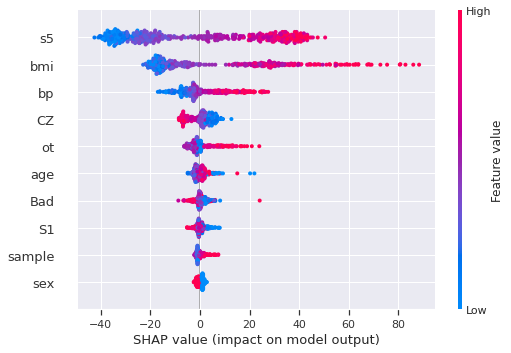

In [ ]:
#@title **SHAP summary plot**
try:
  if dataset_type == 'Regression':
    shap.summary_plot(shap_values=shap_values)
except:
  print('skip')

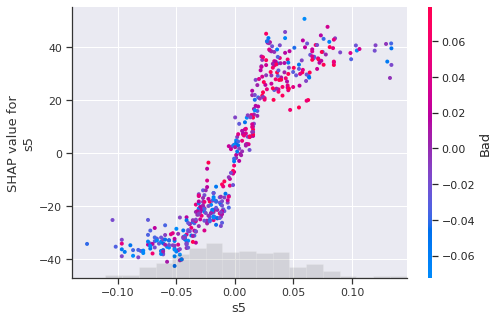

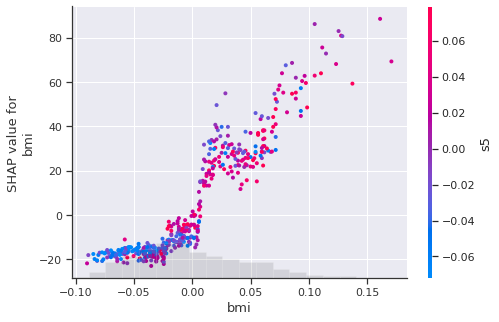

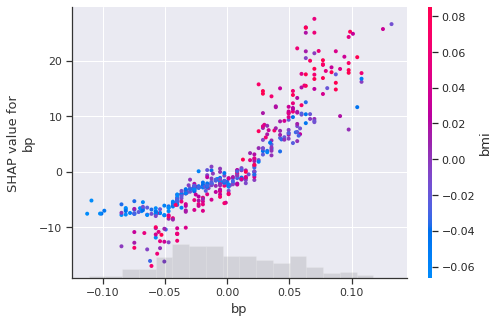

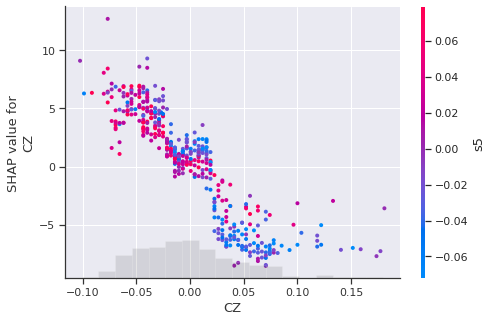

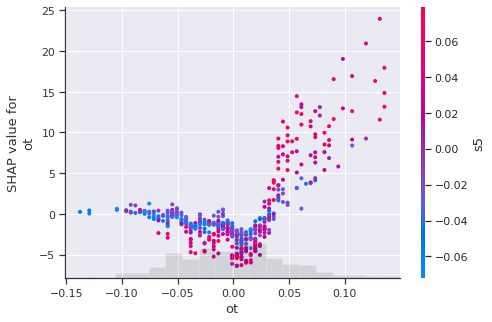

In [ ]:
#@title **SHAP scatter plot**（feature[X] vs. SHAP[y]｜表示数設定：2～10）{ run: "auto" }
#X軸にその特徴の値、Y軸に同じ特徴のSHAP値をプロット。モデルが与えられた特徴にどのように依存するかを示す。垂直方向の分散は相互作用効果を表す。

Number_of_graphs_shown = 5 #@param {type:"slider", min:2, max:10, step:1}

try:
  for i in range(Number_of_graphs_shown):
    shap.plots.scatter(shap_values[:,df3['col_names'][i]], color=shap_values)
except:
  print('skip')

# color引数にshap値の変数を指定すると、自動的に適した変数が選択される
#shap.plots.scatter(shap_values[:, "RM"], color=shap_values)　#カラム指定方法
#shap.plots.scatter(shap_values[:,"DIS"], alpha=0.5)          #ノーマル散布図　　　　

### **Desision Tree**
<details><summary>Decision tree について</summary><div>
決定木はシンプルなほど解釈しやすくなりますので、まずは可読性を重視した決定木を出力するようにしています。（木の深さは2～6に任意設定できます）

※以下、Noteではデータを訓練用とテスト用に分割し、パラメーターチューニングにより最適化を図った条件で描いたDesicionTreeも表示させるようにしています。

*   #orientation='LR' の # を消すと、決定木の表示は横向きになります。
*   予測したいXの値を X=[X1,X2,X3,X4,…] とすると予測値が表示されます。

-----------------------------------------------------------------------------------------
[最適パラメータ]
DecisionTreeRegressor(max_depth=3, min_samples_leaf=8, random_state=0)
-----------------------------------------------------------------------------------------


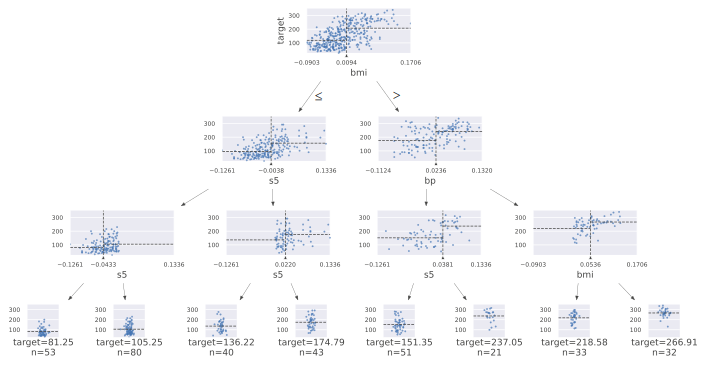

In [ ]:
#@title **DecisionTree**（GridSearchによるパラメータ最適化Ver.）

#X,yを再セット
FEATURES = X_selected.columns
TARGET = df.columns[-1]
X = X_selected.loc[:, FEATURES]
y = df.loc[:, TARGET]

#dtreeviz import
from dtreeviz.trees import *

#testとtrainを分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size = 0.20, random_state = 1)

#ライブラリインポート
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#GridSearch実行
if dataset_type == 'Classification':
  dtr = DecisionTreeClassifier(random_state=0)

else:
  dtr = DecisionTreeRegressor(random_state=0)

gs_dtr = GridSearchCV(dtr,
                      param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7],
                      'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
                      cv = 10)

gs_dtr.fit(X_train, y_train)

#パラメータ最適化 ⇒ DecisionTree出力
if dataset_type == 'Classification':
  viz = dtreeviz(gs_dtr.best_estimator_,
               X_train,
               y_train,
               target_name = TARGET,
               feature_names = FEATURES,
               fontname='DejaVu Sans',
               #orientation='LR',
               #X = [3,3,5,3],
               class_names = list(y.unique())
              )

else:
  viz = dtreeviz(gs_dtr.best_estimator_,
               X_train,
               y_train,
               target_name = TARGET,
               feature_names = FEATURES,
               fontname='DejaVu Sans',
               #orientation='LR',
               #X = [3,3,5,3]
              )
print('-----------------------------------------------------------------------------------------')
print('[最適パラメータ]')
print(gs_dtr.best_estimator_)
print('-----------------------------------------------------------------------------------------')
viz

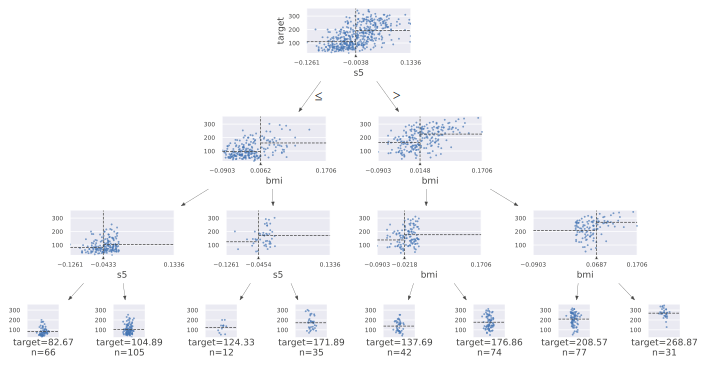

In [ ]:
#@title **Desision Tree**（決定木 深さ設定｜max_depth：2～6｜☑ ＝実行） { run: "auto" }
#Display_decision_tree = True #@param {type:"boolean"}

max_depth = 3 #@param {type:"slider", min:2, max:6, step:1}


if dataset_type == 'Classification':
  CLASS_NAME = list(y.unique())
  dtree = tree.DecisionTreeClassifier(max_depth=max_depth)
  dtree.fit(X_selected,y)
  viz = dtreeviz(dtree,X_selected,y,
               target_name = TARGET,
               feature_names = FEATURES,
               #orientation='LR',
               class_names = CLASS_NAME,
               fontname='DejaVu Sans',
               #X = [3,3,3,5,3]
              )

if dataset_type == 'Regression':
  dtree = tree.DecisionTreeRegressor(max_depth=max_depth)
  dtree.fit(X_selected,y)
  viz = dtreeviz(dtree,X_selected,y,
               target_name = TARGET,
               feature_names = FEATURES,
               fontname='DejaVu Sans',
               #orientation='LR',
               #X = [3,3,5,3]
              )

#if Display_decision_tree == True:
#  viz

viz

In [ ]:
#@title **Decision tree 画像出力（☑ ＝実行）**  { run: "auto" }

Decision_tree_best_output = False #@param {type:"boolean"}
Decision_tree_output = False #@param {type:"boolean"}

if Decision_tree_output == True:
  viz.save('Decission_tree_result.svg')

if Decision_tree_best_output == True:
  viz.save('Decission_tree_best_result.svg')

### **Note**

In [ ]:
#@title **DataPrep html Report Output**
#create_report(df)
'''
report = create_report(df)
report.save('DataPrep_Report')

from google.colab import files
files.download( "/content/DataPrep_Report.html" )
''' 

'\nreport = create_report(df)\nreport.save(\'DataPrep_Report\')\n\nfrom google.colab import files\nfiles.download( "/content/DataPrep_Report.html" )\n'

- https://yaakublog.com/boruta_feature_selection
- https://github.com/scikit-learn-contrib/boruta_py
- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
- https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html
- https://github.com/maskot1977/scikitallstars/blob/main/scikitallstars/feature_selector.py
- https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/plots/scatter.html
- https://stackoverflow.com/questions/65534163/get-a-feature-importance-from-shap-values
- https://github.com/slundberg/shap/issues/632

In [ ]:
#@title **目的変数 maxデータ・minデータのindex**

if dataset_type == 'Regression':
  print("Max_data ⇒ index：",df.iloc[:,-1].idxmax())
  print("Min_data ⇒ index：",df.iloc[:,-1].idxmin())
else:
  print('Dataset = Classification')

Max_data ⇒ index： 256
Min_data ⇒ index： 156


In [ ]:
#@title **特徴量選択後 データフレーム**

Display_dataframe = False #@param {type:"boolean"}

#Display not/go
if Display_dataframe == True:
  print('選択後のデータ数,特徴量数：',X_selected.shape)
  display(X_selected)

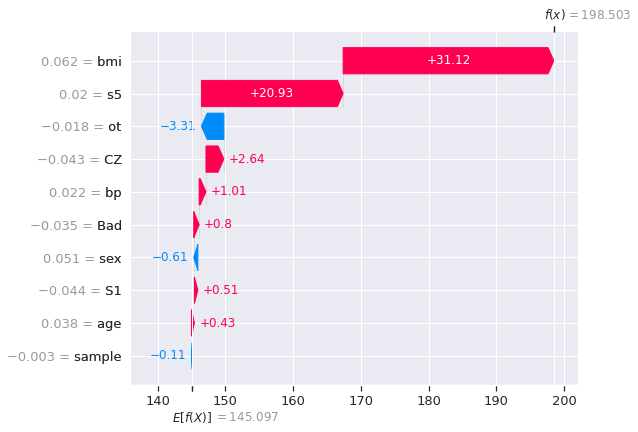

In [ ]:
#@title **Waterfall_plot** 　～index番号変更 ⇒ 各データの特徴量の寄与度を可視化～
index =  0#@param {type:"raw"}  { run: "auto" }

try:
  index = index #表示するサンプルのインデックスを指定
  shap.waterfall_plot(shap_values[index])
except:
  print('skip')
